# Hyperparameter search on the BBBP data set

This is a more advanced example of how to use MolPipeline in combination with Sklearn to make molecular machine learning experiments. In this notebook we show how hyperparameter optimization can be performed using MolPipeline and Sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). We will train multiple Sklearn estimators (like RandomForest) with Morgan fingerprints and scaffold splits and select the best performing model.

We selected the BBBP data sets from [MoleculeNet](https://moleculenet.org/) because it is a widely used data sets for benchmarking molecular property prediction methods and it contains some problematic molecules that are erroneous which highlights the error handling capabilities of MolPipeline. See [the blog post](http://practicalcheminformatics.blogspot.com/2023/08/we-need-better-benchmarks-for-machine.html) by Patrick Walters for details on the erroneous molecules.

In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from molpipeline.pipeline import Pipeline
from molpipeline.pipeline_elements.any2mol import AutoToMolPipelineElement

from molpipeline.pipeline_elements.mol2mol import (
    CanonicalizeTautomerPipelineElement,
    MetalDisconnectorPipelineElement,
    RemoveStereoInformationPipelineElement,
    SaltRemoverPipelineElement,
    UnchargePipelineElement,
    SolventRemoverPipelineElement,
)

from molpipeline.pipeline_elements.mol2mol.mol2mol_filter import (
    ElementFilterPipelineElement,
)

from molpipeline.pipeline_elements.mol2any import MolToFoldedMorganFingerprint

from molpipeline.pipeline_elements.error_handling import (
    ErrorFilter,
    ErrorReplacer,
)
from molpipeline.pipeline_elements.post_prediction import PostPredictionWrapper

from molpipeline.sklearn_estimators.murcko_scaffold_clustering import (
    MurckoScaffoldClustering,
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

In [2]:
N_JOBS = 16
RANDOM_STATE = 67056

Let's start by getting the data set

In [3]:
df = pd.read_csv(
    "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv",
    usecols=lambda col: col != "num",
)
df

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...
2045,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


Make a function to setup some pipeline elements for standardization that we will use later

In [4]:
def make_standardization_elements():
    """Make a new list of pipeline elements for molecular standardization."""
    return [
        (
            "element_filter",
            ElementFilterPipelineElement(
                allowed_element_numbers=[
                    1,
                    3,
                    5,
                    6,
                    7,
                    8,
                    9,
                    11,
                    12,
                    14,
                    15,
                    16,
                    17,
                    19,
                    20,
                    34,
                    35,
                    53,
                ]
            ),
        ),
        ("metal_disconnector", MetalDisconnectorPipelineElement()),
        ("salt_remover", SaltRemoverPipelineElement()),
        ("uncharge", UnchargePipelineElement()),
        ("canonical_tautomer", CanonicalizeTautomerPipelineElement()),
        ("stereo_remover", RemoveStereoInformationPipelineElement()),
    ]

### Make a clustering pipeline

We first setup a pipeline that will do the scaffold clustering for us using [Murcko scaffolds](https://www.rdkit.org/docs/GettingStartedInPython.html#murcko-decomposition).

In this example we also use Molpipelines error handling to detect and filter out all invalid molecules before clustering. After clustering we will re-add fill-values(np.nan in this case) at the corresponding positions of the invalid molecules. This keeps the resulting list of cluster labels (also called 'groups') in the same shape as the input molecule list. 

In [5]:
# create an error error filter and replacer.
error_filter = ErrorFilter()
# the replacer is wrapper into a PostPredictionWrapper because we execute
# the replacement step at the end of the pipeline, even after the clustering.
error_replacer = PostPredictionWrapper(
    ErrorReplacer.from_error_filter(error_filter, np.nan)
)

# set up the clustering pipeline
pipeline_clustering = Pipeline(
    [("auto2mol", AutoToMolPipelineElement())]
    + make_standardization_elements()
    + [
        ("error_filter", error_filter),  # filter out invalid samples before clustering
        (
            "scaffoldClustering",
            MurckoScaffoldClustering(linear_molecules_strategy="own_cluster"),
        ),
        (
            "error_replacer",
            error_replacer,
        ),  # re-add fill values to invalid samples to keep input shape
    ],
    n_jobs=N_JOBS,
)

# cluster the smiles by their murcko scaffold
groups = pipeline_clustering.fit_predict(df["smiles"])

# the 'groups' are the cluster labels
groups

array([ 993., 1001.,  671., ...,  324.,  715., 1001.])

We can have a look at the clustering results by plotting the distribution of cluster sizes.

Number of cluster: 1033


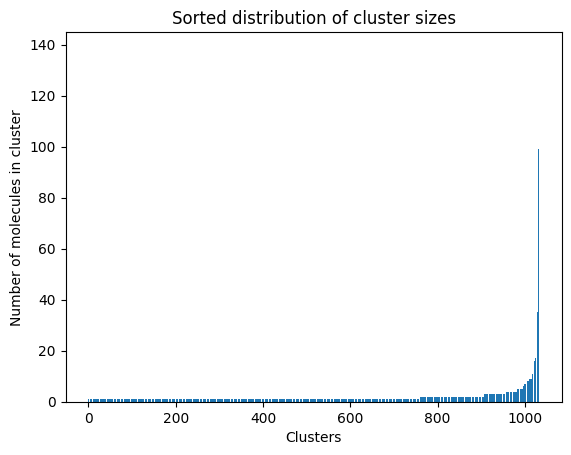

In [6]:
values, counts = np.unique(groups, return_counts=True)
print("Number of cluster:", len(values))
plt.bar(range(len(counts)), sorted(counts))
plt.xlabel("Clusters")
plt.ylabel("Number of molecules in cluster")
_ = plt.title("Sorted distribution of cluster sizes")

### Analyzing failed molecules

For the BBBP data sets some molecules fail the processing by the clustering pipeline.
Analysing the molecules that failed is an optional step but can give interesting insights.

Since we set replaced all failed molecules with np.nan we can count them with numpy's isnan function 

In [7]:
np.isnan(groups).sum()

11

Using the nan values in the `groups` array we can map back to the original molecules in the BBBP data set.

In [8]:
df["smiles"][np.isnan(groups)]

59          O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
61            c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
391                             Cc1nc(sc1)\[NH]=C(\N)N
614          s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
642                c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
645                      n1c(csc1\[NH]=C(\N)N)c1ccccc1
646                   n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
647             n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
648    n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
649                             s1cc(nc1\[NH]=C(\N)N)C
685             c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
Name: smiles, dtype: object

These molecules contain uncharged tetravalent nitrogen atoms which is not correct. Therefore, these SMILES represent invalid structures and RDKit can't read them. See [Pat Walters great blog post](http://practicalcheminformatics.blogspot.com/2023/08/we-need-better-benchmarks-for-machine.html) for more details. Molpipeline can automatically handle these cases through it's error handling. Without the error handling the execution of the pipeline would fail and we would have to make manually interventions.   

### Group clusters into train/valid/test split

We now will group the computed clusters into train/valid/test splits that we can use with Sklearn's GridSearchCV. The split ratio we choose is 80/10/10.

In [9]:
TEST_SET_SIZE = 0.1  # 10%
VALID_SET_SIZE = 0.1  # 10%

# create a mask to remove invalid samples from all data
valid_grouping_mask = ~np.isnan(groups)

# we first make a 90/10 split to create the hold-out test set
grouper_test = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=RANDOM_STATE)

# test_indices are the indices of the hold-out test set.
tmp_indices, test_indices = next(
    grouper_test.split(
        df[valid_grouping_mask]["smiles"],
        df[valid_grouping_mask]["p_np"],
        groups=groups[valid_grouping_mask],
    )
)

# calculate what 10% of the full data set is on the 90% chunk
propotion_valid_set = df["smiles"].shape[0] * VALID_SET_SIZE / len(tmp_indices)

# then, we split the 90% of the data again to create a train and a valid set.
grouper_valid = GroupShuffleSplit(
    n_splits=1, test_size=propotion_valid_set, random_state=RANDOM_STATE
)

# the 10% as hold-out test set
df_test = df[valid_grouping_mask].iloc[test_indices, :]

# the 90% containing both train and valid set (will be used later with the grouper_valid)
df_train_and_valid = df[valid_grouping_mask].iloc[tmp_indices, :]
df_train_and_valid

,name,p_np,smiles
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
5,cefoperazone,1,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...
...,...,...,...
2043,zometapine,1,C3=C(C1=NCCN=C2N(NC(=C12)C)C)C=CC=C3Cl
2044,nitrous-oxide,1,[N+](=[N-])=O
2045,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2047,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...


### Hyperparameter search and model selection

Here we will use Sklearn's GridSearchCV with Molpipeline to determine the best hyperparameter configuration on BBBP using the train and valid data sets. Afterwards we can determine the best models' performance on the hold-out test set.

Before starting the actual hyperparameter search we pre-compute the standardized molecules. While this pre-computation is not strictly necessary this gives a speed up of about 5-6x for the whole hyperparameter search. The slowest step in the standardization is finding a canonical tautomer. By pre-computation the canonical tautomer is determined once and not for each hyperparameter combination.

In [10]:
%%time

# Let's pre-compute the molecular standardization
pipeline_standardization = Pipeline(
    [("auto2mol", AutoToMolPipelineElement())] + make_standardization_elements(),
    n_jobs=N_JOBS,
)

stand_smiles = pipeline_standardization.transform(df_train_and_valid["smiles"])

CPU times: user 465 ms, sys: 231 ms, total: 696 ms
Wall time: 10.8 s


Let's do the hyperparameter search

In [11]:
%%time

# setup the estimators and their hyperparameters we want to consider in the grid search
estimators_types = [RandomForestClassifier, KNeighborsClassifier, LogisticRegression]
estimators_grid_spaces = {
    RandomForestClassifier.__name__: {
        "n_estimators": [200, 1000],
        "max_depth": [8, 32, 128, None],
        "min_samples_split": [2, 5, 7],
        "min_samples_leaf": [1, 3, 5],
        "random_state": [RANDOM_STATE],
    },
    KNeighborsClassifier.__name__: {
        "n_neighbors": [3, 5],
        "metric": ["jaccard"],
        "weights": ["uniform", "distance"],
    },
    LogisticRegression.__name__: {
        "C": [0.001, 0.1, 1, 10, 100, 1000],
        "max_iter": [1000],
        "random_state": [RANDOM_STATE],
    },
}

# Molpipline let's you also natively include hyperparameters of the descriptor
morgan_grid_spaces = {"morgan__n_bits": [1024, 2048], "morgan__radius": [1, 2]}

# we loop over all estimators and do a grid search separately
cv_dict = {}
for estimator_type in estimators_types:

    pipeline_estimator = Pipeline(
        [("auto2mol", AutoToMolPipelineElement())]
        + [("morgan", MolToFoldedMorganFingerprint(output_datatype="dense"))]
        + [("estimator", estimator_type())],
        n_jobs=N_JOBS,
    )

    pipeline_param_grid = {
        f"estimator__{k}": v
        for k, v in estimators_grid_spaces[estimator_type.__name__].items()
    }
    pipeline_param_grid.update(morgan_grid_spaces)

    cv = GridSearchCV(
        estimator=pipeline_estimator,
        param_grid=pipeline_param_grid,
        cv=grouper_valid,
        scoring="roc_auc",
        n_jobs=N_JOBS,
    )

    cv.fit(
        X=stand_smiles,
        y=df_train_and_valid["p_np"],
        groups=groups[valid_grouping_mask][tmp_indices],
    )

    cv_dict[estimator_type.__name__] = cv

/home/siegjo/miniconda3/envs/ml24_1/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/siegjo/miniconda3/envs/ml24_1/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/siegjo/miniconda3/envs/ml24_1/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/siegjo/miniconda3/envs/ml24_1/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/siegjo/miniconda3/envs/ml24_1/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted

CPU times: user 1min 40s, sys: 3.86 s, total: 1min 44s
Wall time: 3min 53s


Let's have a look at the best estimators selected with the grid search

In [12]:
best_estimators = [cv.best_estimator_ for _, cv in cv_dict.items()]
best_estimators

[Pipeline(n_jobs=16,
          steps=[('auto2mol', AutoToMolPipelineElement()),
                 ('morgan',
                  MolToFoldedMorganFingerprint(radius=1, output_datatype=dense)),
                 ('estimator',
                  RandomForestClassifier(max_depth=128, n_estimators=200,
                                         random_state=67056))]),
 Pipeline(n_jobs=16,
          steps=[('auto2mol', AutoToMolPipelineElement()),
                 ('morgan',
                  MolToFoldedMorganFingerprint(radius=1, output_datatype=dense)),
                 ('estimator', KNeighborsClassifier(metric='jaccard'))]),
 Pipeline(n_jobs=16,
          steps=[('auto2mol', AutoToMolPipelineElement()),
                 ('morgan',
                  MolToFoldedMorganFingerprint(radius=1, n_bits=1024, output_datatype=dense)),
                 ('estimator',
                  LogisticRegression(C=1, max_iter=1000, random_state=67056))])]

The three estimators achieved the following ROC AUCs on the validation set

In [13]:
best_valid_scores = [cv.best_score_ for _, cv in cv_dict.items()]
best_valid_scores

[0.8882653061224489, 0.843452380952381, 0.8710034013605442]

### Determine performance on the hold-out test set

After selecting the best predictors on the valid set we want to see an estimate of their performance on the hold-out test set  

In [14]:
# pre-compute standardized molecules
pipeline_standardization = Pipeline(
    [("auto2mol", AutoToMolPipelineElement())] + make_standardization_elements(),
    n_jobs=N_JOBS,
)
test_smiles_standardized = pipeline_standardization.transform(df_test["smiles"])

In [15]:
test_roc_aucs = []
for estimator_type, cv in cv_dict.items():
    best_estimator = cv.best_estimator_
    test_predictions = best_estimator.predict_proba(test_smiles_standardized)
    test_roc_aucs.append(roc_auc_score(df_test["p_np"], test_predictions[:, 1]))
    print(
        estimator_type,
        f"valid_roc_auc: {cv.best_score_:.2f}",
        f"test_roc_auc: {test_roc_aucs[-1]:.2f}",
    )

RandomForestClassifier valid_roc_auc: 0.89 test_roc_auc: 0.91


/home/siegjo/miniconda3/envs/ml24_1/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


KNeighborsClassifier valid_roc_auc: 0.84 test_roc_auc: 0.92
LogisticRegression valid_roc_auc: 0.87 test_roc_auc: 0.86


As shown above the best model on the validation set is RandomForestClassifier with an ROC AUC of 0.89, however on the hold-out test set KNeighborsClassifier is slightly better. 

### A plot for the papr TODO 

In [16]:
dict_data = {"mean_test_score": [], "estimator": []}
for estimator_type, cv in cv_dict.items():
    dict_data["mean_test_score"].extend(cv.cv_results_["mean_test_score"])
    dict_data["estimator"].extend(
        [estimator_type] * len(cv.cv_results_["mean_test_score"])
    )

df_cv = pd.DataFrame(dict_data)
df_cv

,mean_test_score,estimator
0,0.833588,RandomForestClassifier
1,0.848980,RandomForestClassifier
2,0.856293,RandomForestClassifier
3,0.819813,RandomForestClassifier
4,0.843197,RandomForestClassifier
...,...,...
323,0.830102,LogisticRegression
324,0.825425,LogisticRegression
325,0.782738,LogisticRegression
326,0.785969,LogisticRegression


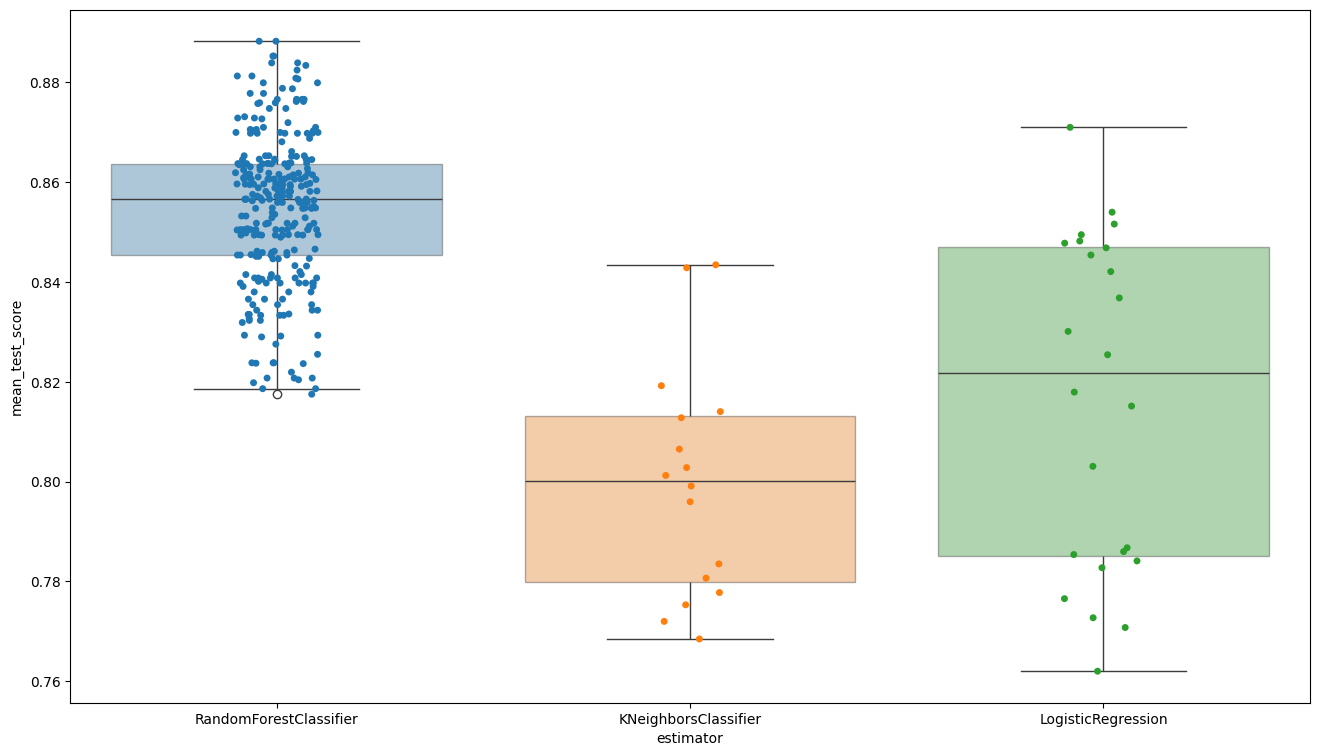

In [17]:
plt.figure(figsize=(16, 9))

ax = sns.boxplot(
    data=df_cv,
    x="estimator",
    y="mean_test_score",
    hue="estimator",
    boxprops={"alpha": 0.4},
    showmeans=False,
)
sns.stripplot(
    data=df_cv,
    x="estimator",
    y="mean_test_score",
    hue="estimator",
    # dodge=True,
    ax=ax,
)
plt.show()